In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.text import OffsetFrom
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import session_info


# Importing and Cleaning Dataset

First, we need to import the dataset. As importing like this can corrupt the mol files, they will be generated and cleaned again in this notebook

In [2]:
drugs = pd.read_csv("../data/approved_drugs.csv")
drugs.drop(["ROMol", "Mol_Clean"], axis=1, inplace=True)
drugs.head()


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,441.160994,6,2,4.37426,oral
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug,240.137497,4,1,2.82270,topical
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,456.194360,6,3,2.71710,oral


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route,ROMol
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,441.160994,6,2,4.37426,oral,

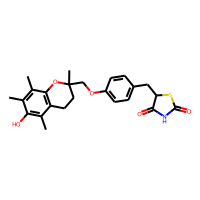

In [3]:
# Add RoMOL column, with mol format
PandasTools.AddMoleculeColumnToFrame(drugs, "SMILES")
drugs.head(1)


Re-running mol generator, and mol cleaning commands

In [4]:
# defining the salts we want to remove from the database
remover = SaltRemover(defnData="[Cl,Br,Na,K,Gd]")

# Defining the function to neutralize the atoms in organic molecules


def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts(
        "[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol


In [5]:
# removing the salts
drugs["Mol_Clean"] = drugs.ROMol.apply(remover.StripMol)

# neutralizing atoms O- goes to OH and so on..
drugs["Mol_Clean"] = drugs.Mol_Clean.apply(neutralize_atoms)


In [6]:
# creating function to print the df without showing the ugly ROMol and Mol_Clean columns
def show_df(df):
    return df.drop(["ROMol", "Mol_Clean"], axis=1)


In [7]:
show_df(drugs.head(5))


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,n_hba,n_hbd,logp,route
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,441.160994,6,2,4.37426,oral
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug,240.137497,4,1,2.82270,topical
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,254.996617,3,1,1.92630,oral
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,567.313078,6,4,4.74762,oral
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,456.194360,6,3,2.71710,oral


# Calculating Veber's descriptors

[Veber's rules for bioavailability](https://pubmed.ncbi.nlm.nih.gov/10746014/):
* Rotatable Bonds <= 10
* Topological Polar Surface Area <= 140
* Total H_Bond Count <= 12

Topological Polar Surface Area and Total H_Bond Count are interchangeable parameters.

In [8]:
# tpsa = topological polar surface area
# rb = rotatable bonds
# h_sum = hydrogen bons sum (hba + hbd)

drugs["tpsa"] = drugs.apply(
    lambda x: Chem.rdMolDescriptors.CalcTPSA(x.Mol_Clean), axis=1)
drugs["rb"] = drugs.apply(
    lambda x: Chem.rdMolDescriptors.CalcNumRotatableBonds(x.Mol_Clean), axis=1)
drugs["h_sum"] = drugs["n_hba"] + drugs["n_hbd"]


In [9]:
# creating boolean columns for each parameter

# RO5
drugs["follow_mw"] = (drugs.mw <= 500).astype(int)
drugs["follow_n_hba"] = (drugs.n_hba <= 10).astype(int)
drugs["follow_n_hbd"] = (drugs.n_hbd <= 5).astype(int)
drugs["follow_logp"] = (drugs.logp <= 5).astype(int)

# Veber's rules
drugs["follow_tpsa"] = (drugs.tpsa <= 140).astype(int)
drugs["follow_rb"] = (drugs.rb <= 10).astype(int)
drugs["follow_h_sum"] = (drugs.h_sum <= 12).astype(int)


In [10]:
drugs.columns


Index(['active_ingredient_moiety', 'nda_bla', 'approval_year', 'active',
       'DrugBank ID', 'Drug Groups', 'SMILES', 'Name', 'Drug Type', 'mw',
       'n_hba', 'n_hbd', 'logp', 'route', 'ROMol', 'Mol_Clean', 'tpsa', 'rb',
       'h_sum', 'follow_mw', 'follow_n_hba', 'follow_n_hbd', 'follow_logp',
       'follow_tpsa', 'follow_rb', 'follow_h_sum'],
      dtype='object')

In [11]:
show_df(drugs.head(5))


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,...,tpsa,rb,h_sum,follow_mw,follow_n_hba,follow_n_hbd,follow_logp,follow_tpsa,follow_rb,follow_h_sum
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,441.160994,...,84.86,5,8,1,1,1,1,1,1,1
1,imiquimod,NDA,1997,imiquimod,DB00724,approved; investigational,CC(C)CN1C=NC2=C1C1=C(C=CC=C1)N=C2N,Imiquimod,SmallMoleculeDrug,240.137497,...,56.73,2,5,1,1,1,1,1,1,1
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,254.996617,...,44.70,0,4,1,1,1,1,1,1,1
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,567.313078,...,101.90,9,10,0,1,1,1,1,1,1
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,456.194360,...,110.43,6,9,1,1,1,1,1,1,1


In [12]:
# saving dataset with all parameters calculated

drugs.to_csv("../data/approved_drugs_final.csv", index=False)


# Separating drugs with oral route

In [13]:
drugs_oral = drugs[drugs.route == 'oral'].copy()
show_df(drugs_oral.head(5))


,active_ingredient_moiety,nda_bla,approval_year,active,DrugBank ID,Drug Groups,SMILES,Name,Drug Type,mw,...,tpsa,rb,h_sum,follow_mw,follow_n_hba,follow_n_hbd,follow_logp,follow_tpsa,follow_rb,follow_h_sum
0,troglitazone,NDA,1997,troglitazone,DB00197,approved; investigational; withdrawn,CC1=C(C)C2=C(CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O)C...,Troglitazone,SmallMoleculeDrug,441.160994,...,84.86,5,8,1,1,1,1,1,1,1
2,anagrelide hydrochloride,NDA,1997,anagrelide,DB00261,approved,ClC1=CC=C2N=C3NC(=O)CN3CC2=C1Cl,Anagrelide,SmallMoleculeDrug,254.996617,...,44.70,0,4,1,1,1,1,1,1,1
3,nelfinavir mesylate,NDA,1997,nelfinavir,DB00220,approved,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC...,Nelfinavir,SmallMoleculeDrug,567.313078,...,101.90,9,10,0,1,1,1,1,1,1
4,delavirdine mesylate,NDA,1997,delavirdine,DB00705,approved,CC(C)NC1=C(N=CC=C1)N1CCN(CC1)C(=O)C1=CC2=C(N1)...,Delavirdine,SmallMoleculeDrug,456.194360,...,110.43,6,9,1,1,1,1,1,1,1
5,tamsulosin hydrochloride,NDA,1997,tamsulosin,DB00706,approved; investigational,CCOC1=CC=CC=C1OCCN[C@H](C)CC1=CC(=C(OC)C=C1)S(...,Tamsulosin,SmallMoleculeDrug,408.171893,...,99.88,11,8,1,1,1,1,1,0,1


# Graphs

In [14]:
# setting seaborn context for all graphs to increase font and tick size
sns.set_context("poster")


## Parameters distributions

### Topological Polar Surface Area

In [15]:
color_palette = {
    "bars": "#dc3d04",
    "patch": "#fa5300",
    "arrow": "#a73e13",
    "vline": "#264653",
    "countplot_bar1": "#E3564F",
    "countplot_bar2": "#F77D44",
    "line1": "#fe7c25",
    "line2": "#eac77b"
}


In [16]:
def dist_graph(df, col_name, title, xlabel, binwidth, threshold, xlim, ax, fig):

    dist = sns.histplot(
        data=df,
        x=col_name,
        color=color_palette["bars"],
        binwidth=binwidth,
        linewidth=2
    )
    ax.axvline(threshold, color=color_palette["vline"], linestyle="--")
    ax.set_xlim(*xlim)  # setting the xlim
    fig.suptitle(title, fontsize=33, fontweight=1000)
    # dist.set_title("FDA approved drugs (1997-2021)", fontsize=18, fontweight=1000)
    dist.set_xlabel(xlabel, fontweight=1000, fontsize=26)
    dist.set_ylabel("")

    # tick sizes and bold
    plt.setp(ax.get_xticklabels(), fontsize=26, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=26, fontweight=624)

    # adding a shaded region
    ax.add_patch(Rectangle((-100, 0),
                           threshold+100, 5000,
                           fc=color_palette["patch"],
                           ec='none',
                           lw=10, alpha=.2))


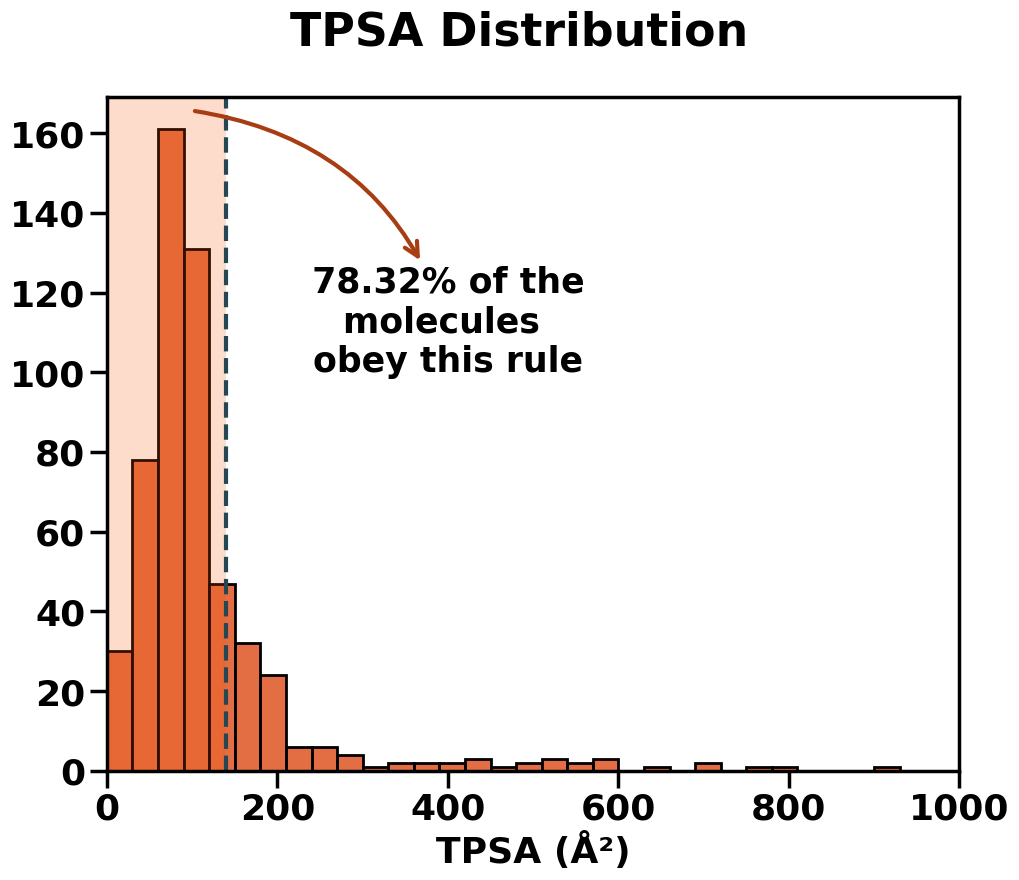

In [17]:
fig, ax = plt.subplots(figsize=(11, 8.75))

dist_graph(
    df=drugs,
    col_name="tpsa",
    title="TPSA Distribution",
    xlabel="TPSA (Å²)",
    binwidth=30,
    threshold=140,
    xlim=(0, 1000),
    ax=ax,
    fig=fig
)

# annotating the information about how % obey the lipinski's rules
param = ((drugs.tpsa <= 140).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.1, 0.98), xycoords='axes fraction',
            xytext=(0.4, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle": "<-",
                        "color": color_palette["arrow"], "lw": 3, "connectionstyle": "arc3,rad=0.3"},
            horizontalalignment='center',
            verticalalignment='top', fontsize=25, fontweight=1000)
# saving plot
fig.savefig("../imgs/veber/dist_tpsa.png", dpi=300)

plt.show()


### Rotatable Bonds

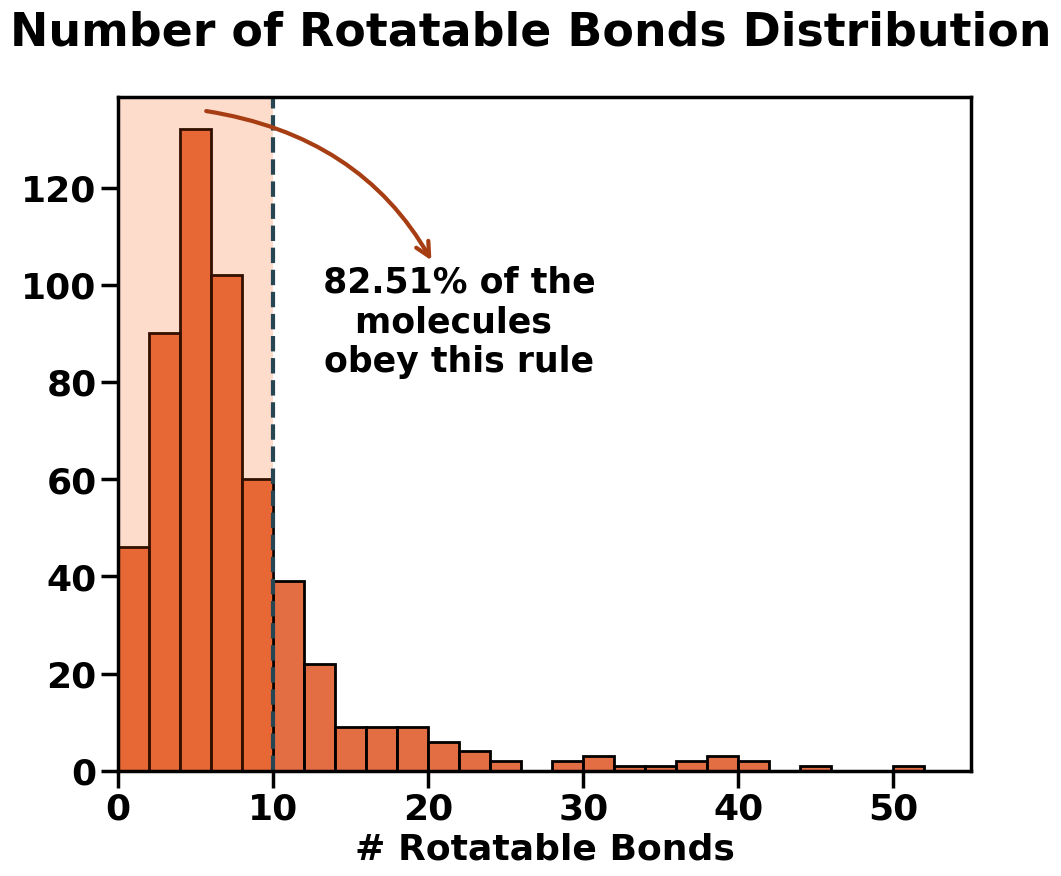

In [18]:
fig, ax = plt.subplots(figsize=(11, 8.75))

dist_graph(
    df=drugs,
    col_name="rb",
    title="Number of Rotatable Bonds Distribution",
    xlabel="# Rotatable Bonds",
    binwidth=2,
    threshold=10,
    xlim=(0, 55),
    ax=ax,
    fig=fig
)

# annotating the information about how % obey the lipinski's rules
param = ((drugs.rb <= 10).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.1, 0.98), xycoords='axes fraction',
            xytext=(0.4, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle": "<-",
                        "color": color_palette["arrow"], "lw": 3, "connectionstyle": "arc3,rad=0.3"},
            horizontalalignment='center',
            verticalalignment='top', fontsize=25, fontweight=1000)
# saving plot
fig.savefig("../imgs/veber/dist_rb.png", dpi=300)

plt.show()


### H-Bond Count

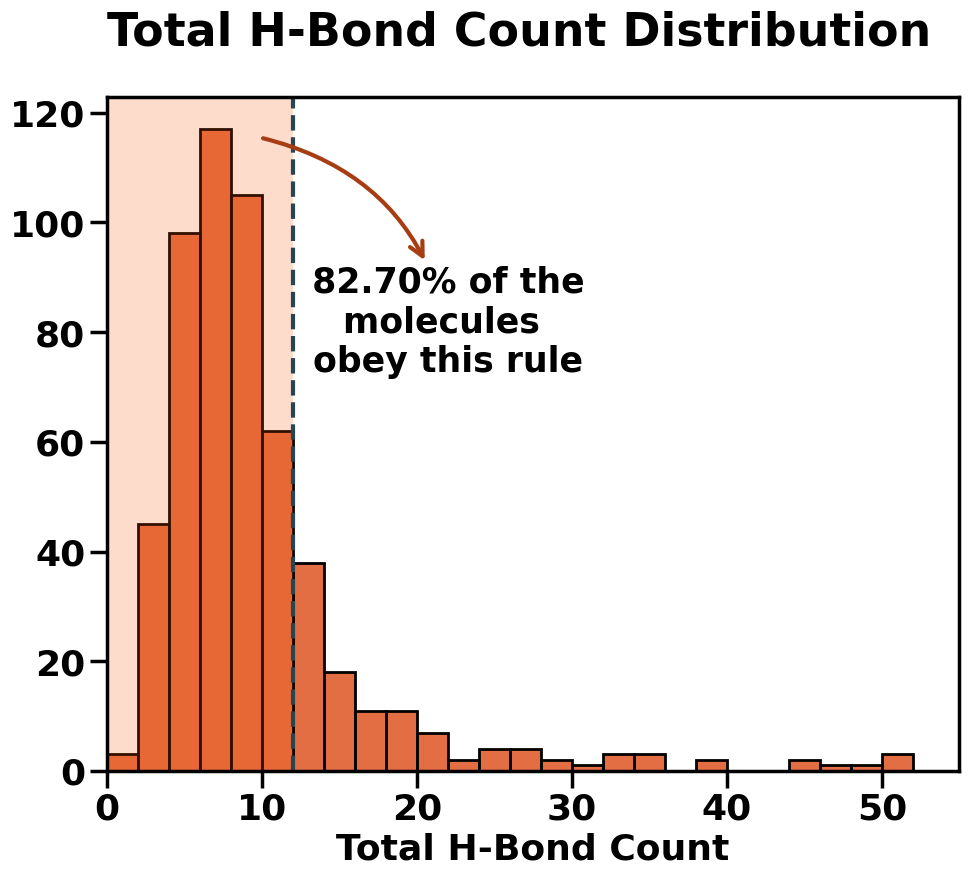

In [19]:
fig, ax = plt.subplots(figsize=(11, 8.75))

dist_graph(
    df=drugs,
    col_name="h_sum",
    title="Total H-Bond Count Distribution",
    xlabel="Total H-Bond Count",
    binwidth=2,
    threshold=12,
    xlim=(0, 55),
    ax=ax,
    fig=fig
)

# annotating the information about how % obey the lipinski's rules
param = ((drugs.h_sum <= 12).sum())/drugs.shape[0]

ax.annotate(f' {param:.2%} of the \nmolecules \nobey this rule',
            xy=(0.18, 0.94), xycoords='axes fraction',
            xytext=(0.4, 0.75), textcoords='axes fraction',
            arrowprops={"arrowstyle": "<-",
                        "color": color_palette["arrow"], "lw": 3, "connectionstyle": "arc3,rad=0.3"},
            horizontalalignment='center',
            verticalalignment='top', fontsize=25, fontweight=1000)
# saving plot
fig.savefig("../imgs/veber/dist_h_sum.png", dpi=300)

plt.show()


# Number of Followed Rules

## Only Veber's Rules

### All drugs

In [20]:
def countplot(df, df_oral, x, title, ylim, file_name, ax):
    COLOR_1 = color_palette["countplot_bar1"]
    COLOR_2 = color_palette["countplot_bar2"]

    # counting bins
    height_all = np.unique(df[x], return_counts=True)[1]
    height_oral = np.unique(df_oral[x], return_counts=True)[1]

    # creating x positions
    x_pos_all = []
    x_pos_oral = []
    x_ticks = []
    for i in range(len(height_all)):
        x_pos_all.append(i+0.17)
        x_pos_oral.append(i-0.17)
        x_ticks.append(i)

    # all drugs plot
    ax.bar(
        x=x_pos_all,
        height=height_all,
        color=COLOR_1,
        label="All approved drugs",
        width=0.3,
        linewidth=2,
        edgecolor="black"
    )

    # oral drugs plot
    ax.bar(
        x=x_pos_oral,
        height=height_oral,
        color=COLOR_2,
        label="Only oral drugs",
        width=-0.3,
        linewidth=2,
        edgecolor="black"
    )

    # Count of each bin
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{}'.format(int(y)), (x.mean(), y),
                    ha='center', va='bottom', fontsize=29, fontweight=1000)  # set the alignment of the text

    # settings
    fig.suptitle(title, fontsize=32, fontweight=1000)

    ax.set_xlabel("Number of rules followed", fontsize=29, fontweight=1000)
    ax.set_ylabel("")

    ax.set_ylim((0, ylim))

    ax.set_xticks(x_ticks)
    ax.set_yticks([i for i in range(0, ylim, 100)])

    plt.setp(ax.get_xticklabels(), fontsize=29, fontweight=627)
    plt.setp(ax.get_yticklabels(), fontsize=29, fontweight=624)

    font = matplotlib.font_manager.FontProperties(
        family="Arial", weight=1000, size=23)
    ax.legend(loc='upper left', prop=font)

    # saving plot
    fig.savefig(f"../imgs/{file_name}.png", dpi=300)


In [21]:
def parameter_selector(df, df_oral, parameters):
    df["countplot"] = 0
    df_oral["countplot"] = 0
    for param in parameters:
        df["countplot"] += df[param]
        df_oral["countplot"] += df_oral[param]


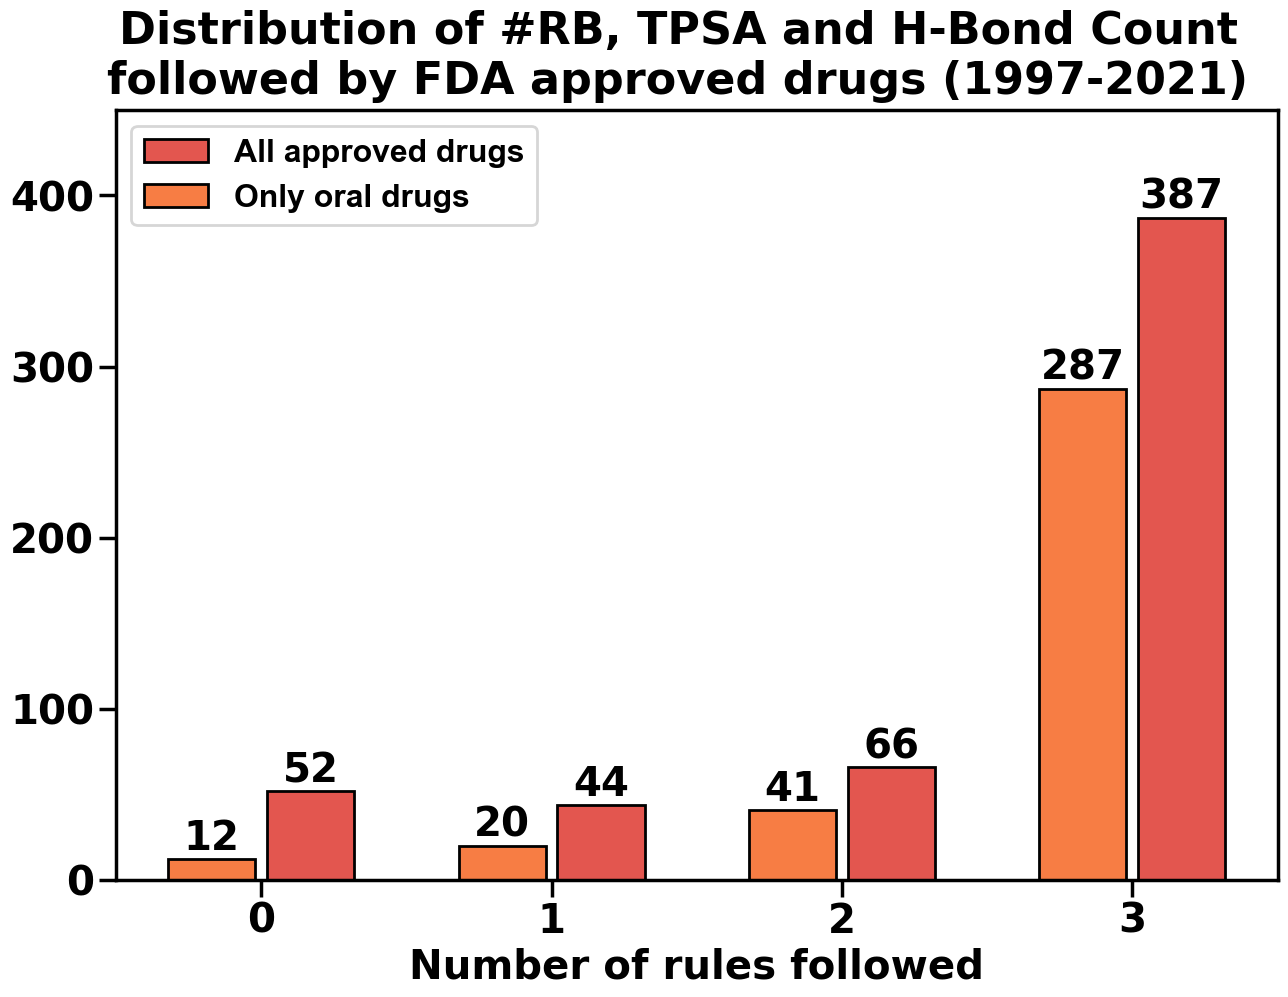

In [22]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_tpsa", "follow_h_sum"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB, TPSA and H-Bond Count\nfollowed by FDA approved drugs (1997-2021)",
    ylim=450,
    file_name="veber/countplot_n_follow_rules_rb_tpsa_hsum",
    ax=ax
)


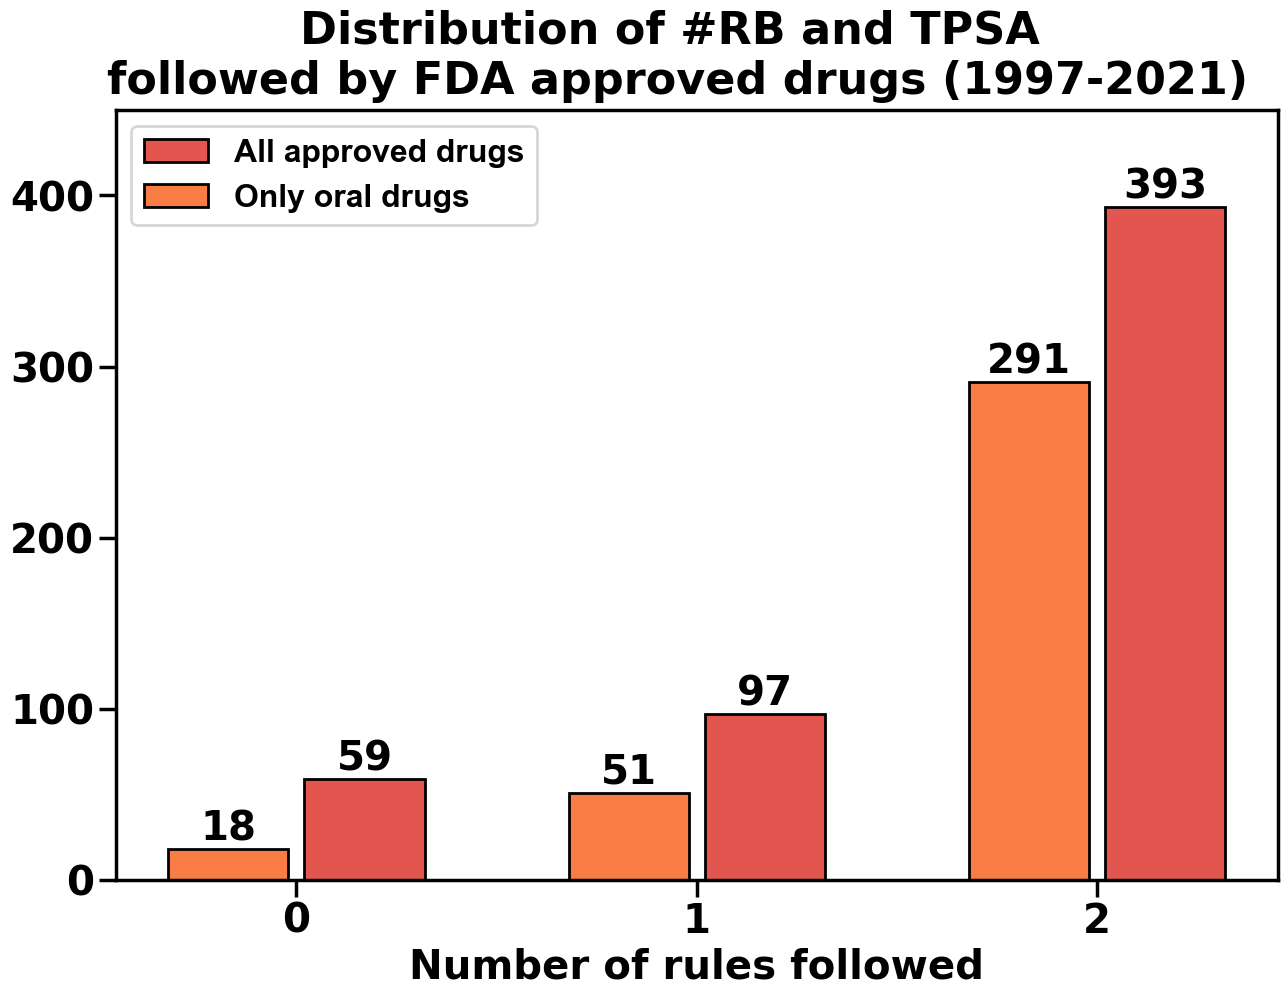

In [23]:
parameter_selector(drugs, drugs_oral, ["follow_rb", "follow_tpsa"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB and TPSA \nfollowed by FDA approved drugs (1997-2021)",
    ylim=450,
    file_name="veber/countplot_n_follow_rules_rb_tpsa",
    ax=ax
)

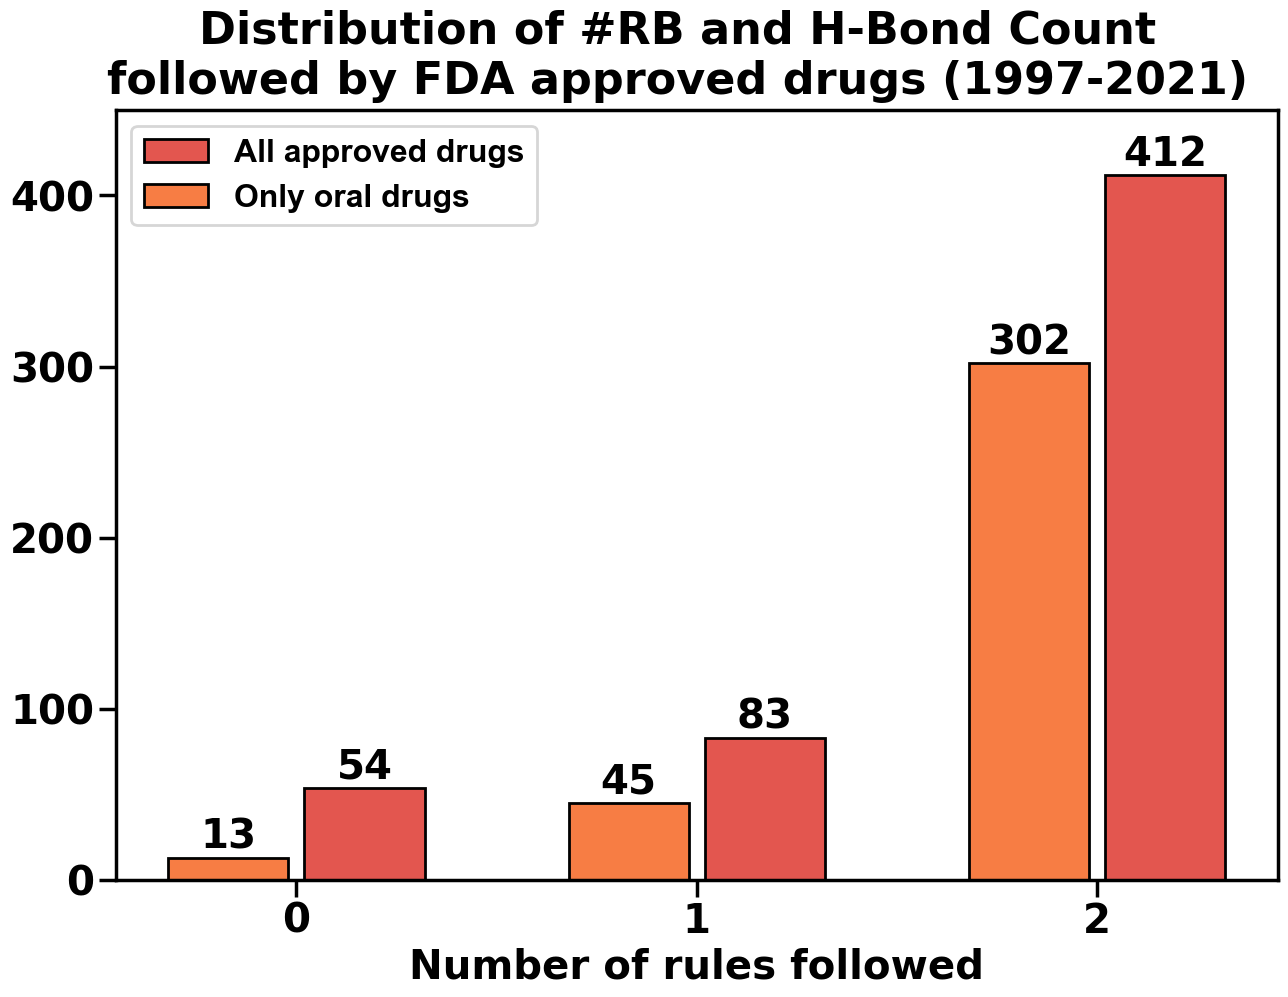

In [24]:
parameter_selector(drugs, drugs_oral, ["follow_rb", "follow_h_sum"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB and H-Bond Count\nfollowed by FDA approved drugs (1997-2021)",
    ylim=450,
    file_name="veber/countplot_n_follow_rules_rb_hsum",
    ax=ax
)


## RO5 + Veber's rules

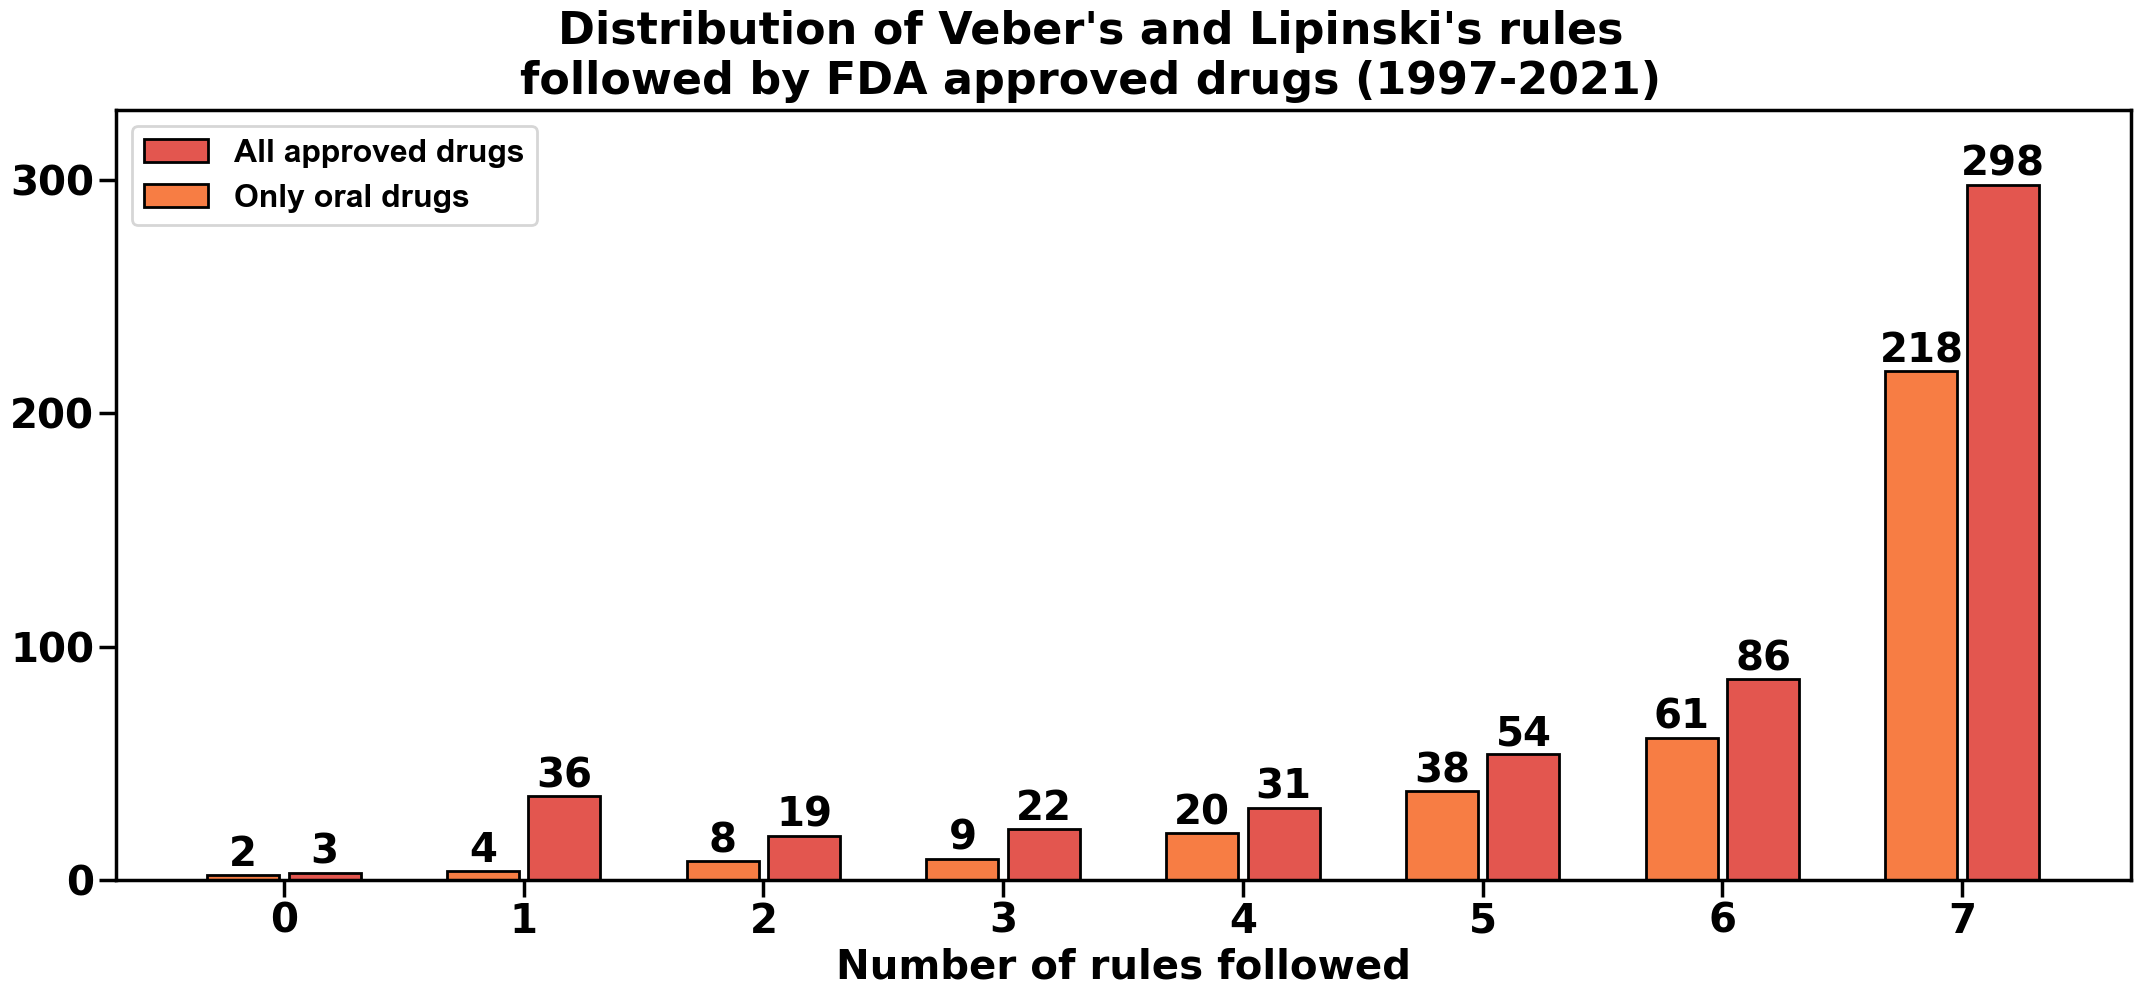

In [25]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_tpsa", "follow_h_sum", "follow_logp", "follow_mw", "follow_n_hba", "follow_n_hbd"])

fig, ax = plt.subplots(figsize=(26, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of Veber's and Lipinski's rules\nfollowed by FDA approved drugs (1997-2021)",
    ylim=330,
    file_name="veber/countplot_n_follow_rules_all_rules",
    ax=ax
)


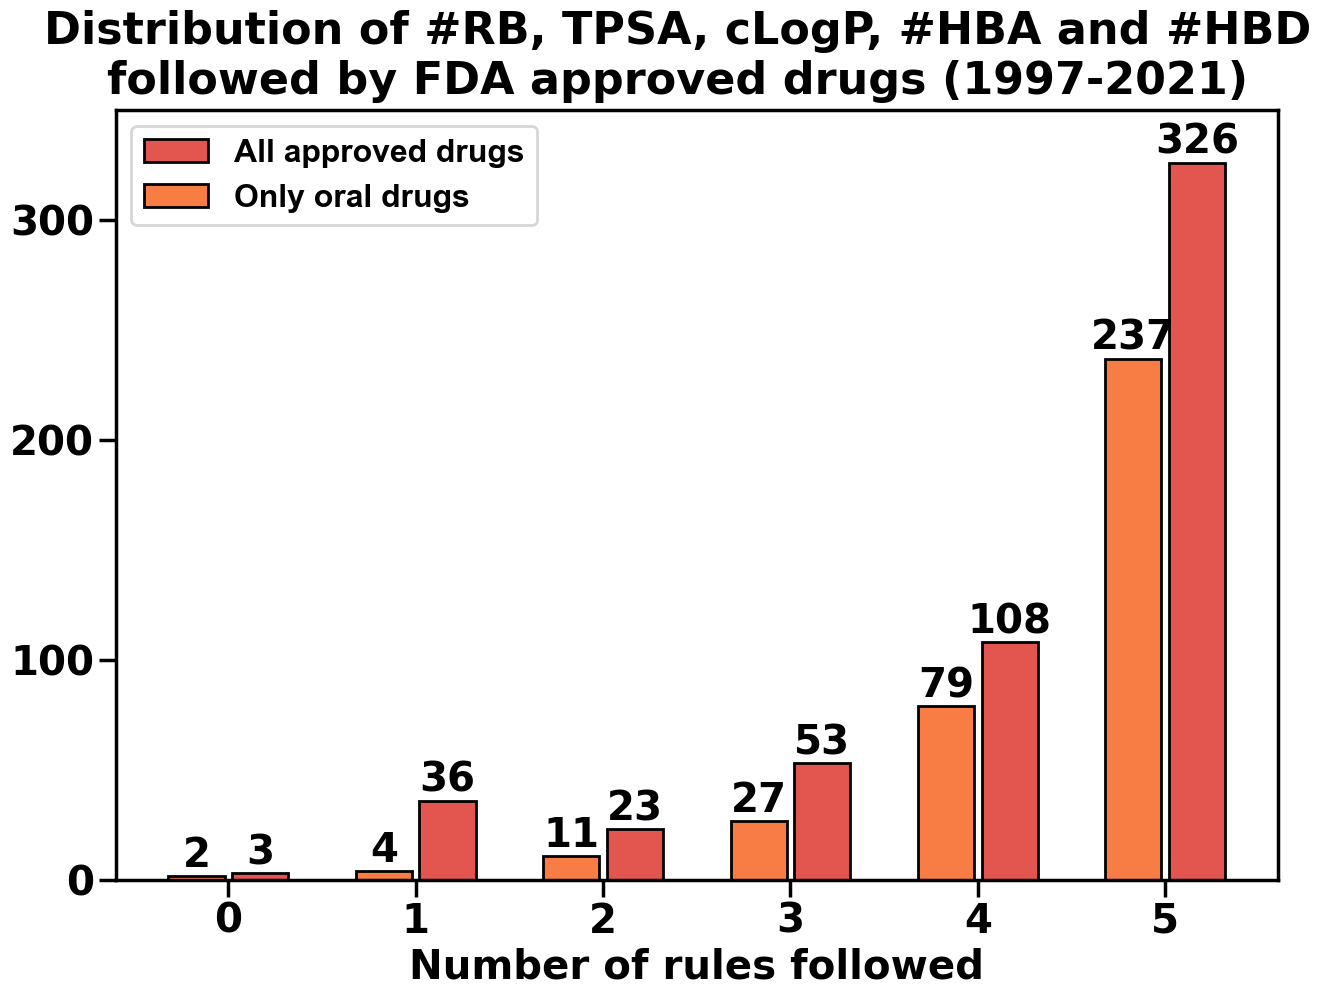

In [26]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_tpsa", "follow_logp", "follow_n_hba", "follow_n_hbd"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB, TPSA, cLogP, #HBA and #HBD\nfollowed by FDA approved drugs (1997-2021)",
    ylim=350,
    file_name="veber/countplot_n_follow_rules_rb_tpsa_logp_hba_hbd",
    ax=ax
)


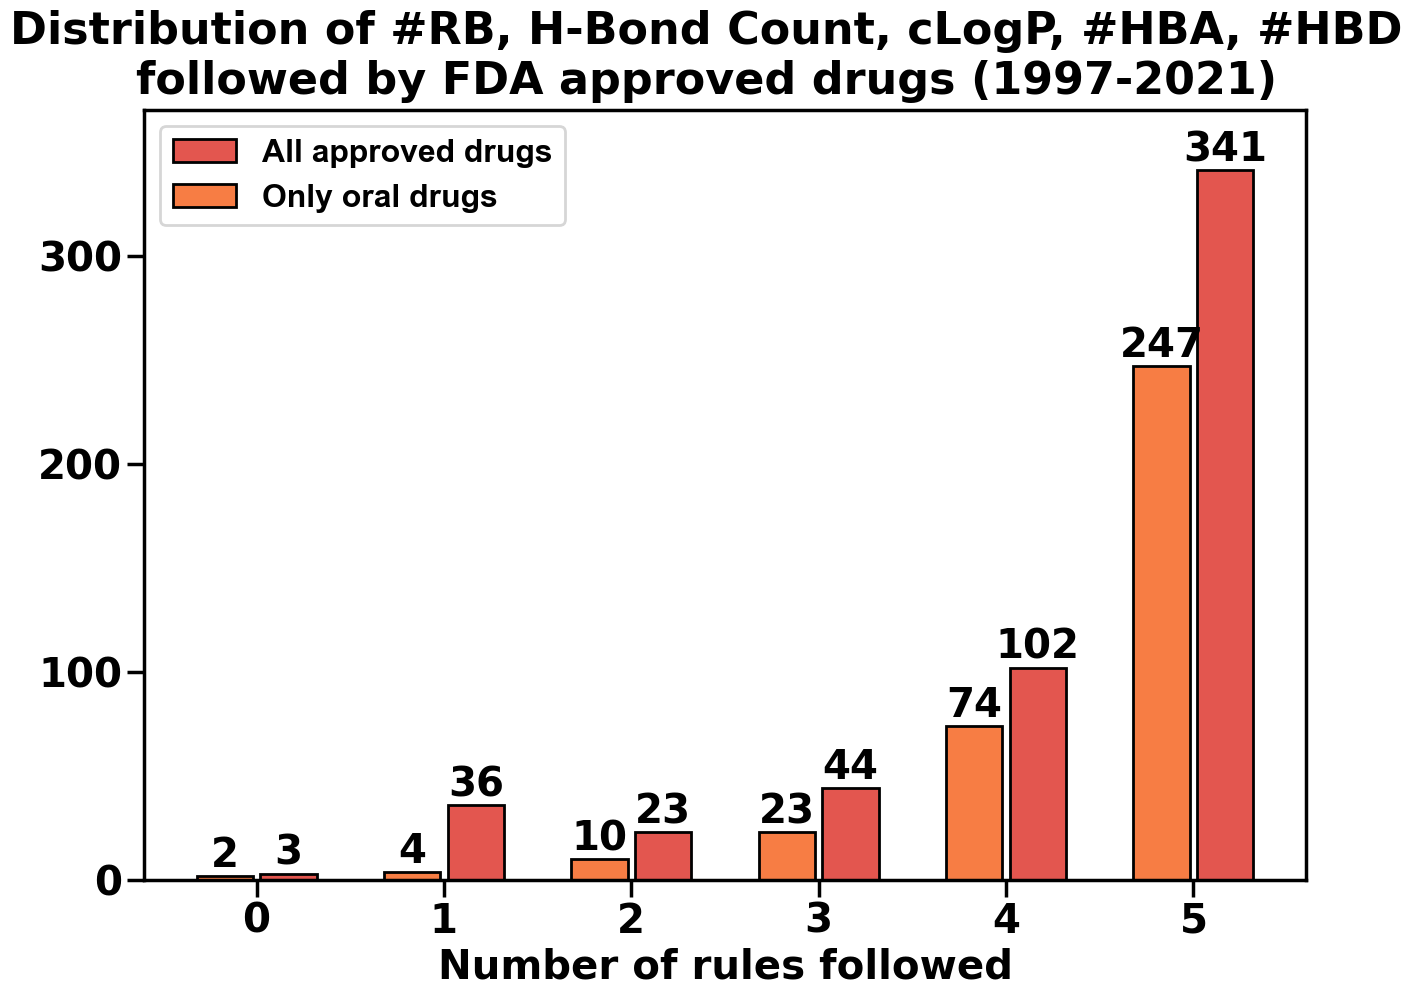

In [27]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_h_sum", "follow_logp", "follow_n_hba", "follow_n_hbd"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB, H-Bond Count, cLogP, #HBA, #HBD\nfollowed by FDA approved drugs (1997-2021)",
    ylim=370,
    file_name="veber/countplot_n_follow_rules_rb_hsum_logp_hba_hbd",
    ax=ax
)


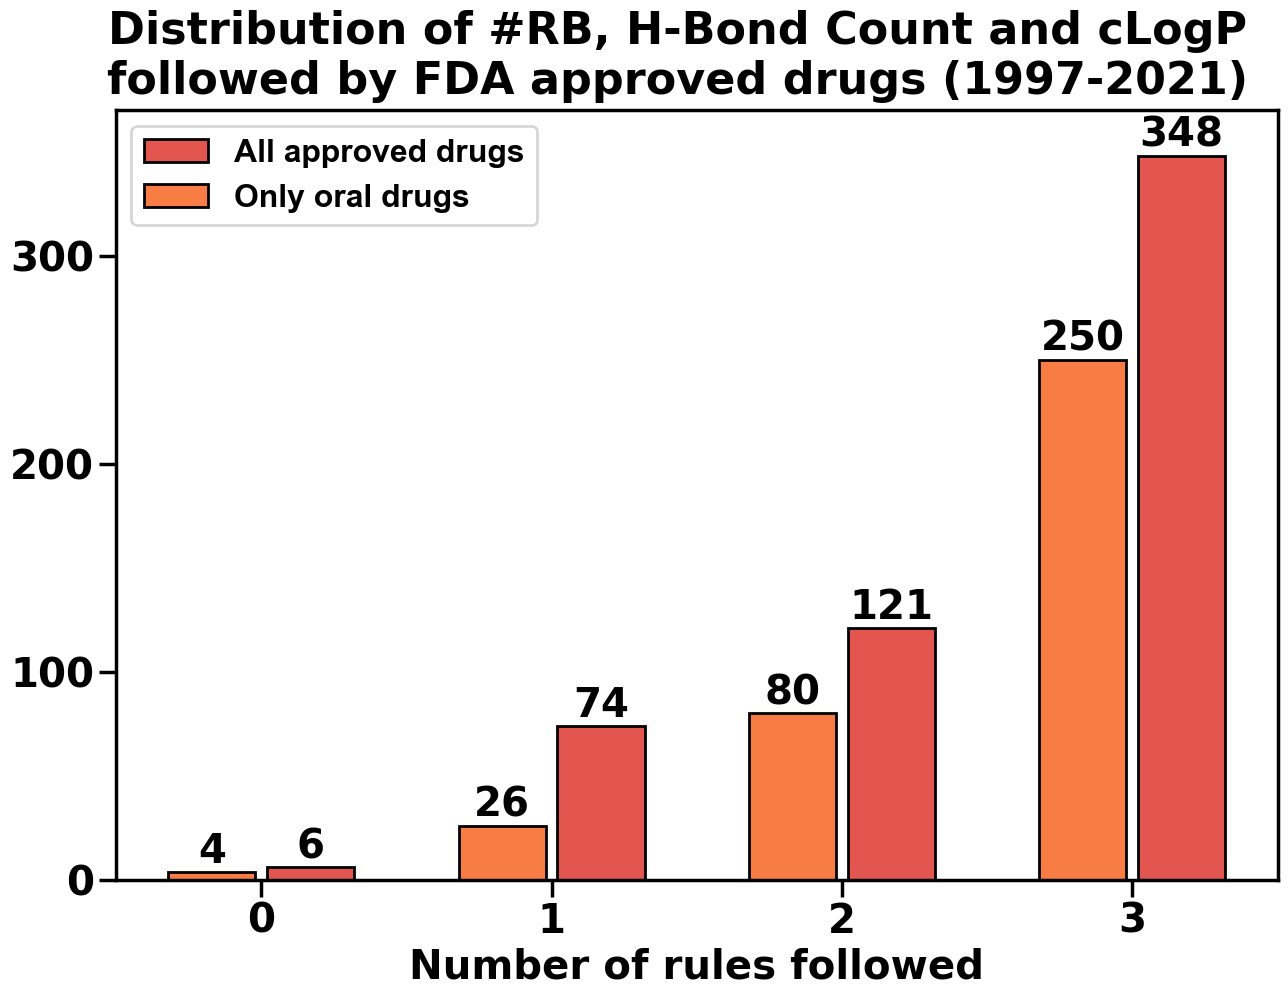

In [28]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_h_sum", "follow_logp"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB, H-Bond Count and cLogP\nfollowed by FDA approved drugs (1997-2021)",
    ylim=370,
    file_name="veber/countplot_n_follow_rules_rb_hsum_logp",
    ax=ax
)


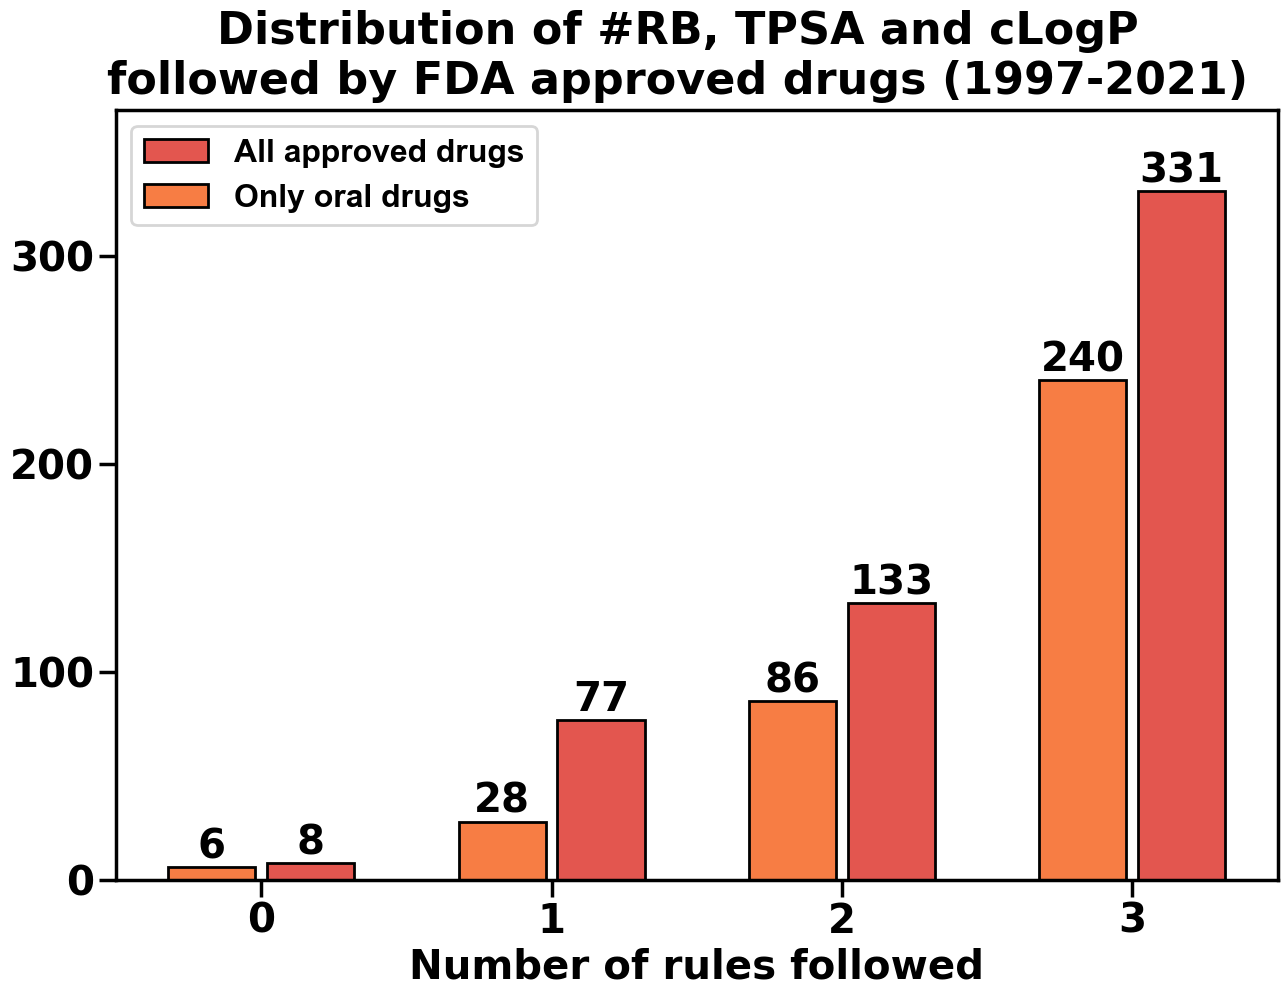

In [29]:
parameter_selector(drugs, drugs_oral, [
                   "follow_rb", "follow_tpsa", "follow_logp"])

fig, ax = plt.subplots(figsize=(15, 10))
countplot(
    df=drugs,
    df_oral=drugs_oral,
    x="countplot",
    title="Distribution of #RB, TPSA and cLogP\nfollowed by FDA approved drugs (1997-2021)",
    ylim=370,
    file_name="veber/countplot_n_follow_rules_rb_tpsa_logp",
    ax=ax
)


## Parameters Change by Year

In [30]:
def change_parameter_name(parameter):
    parameter_change = {"tpsa": "Topological Polar Surface Area",
                        "rb": "# Rotatable Bonds",
                        "h_sum": "H-Bond Count"}
    return parameter_change[parameter]


In [31]:
def parameter_by_year(df, parameter, fig, ax, loc, ylim):
    # groupby by year
    df_groupby_year = df.groupby("approval_year")

    # creating a dataset with the mean and median of the parameter in each year
    df_years = pd.DataFrame(
        columns=["year", f"{parameter}_mean", f"{parameter}_median"])

    for year, df in df_groupby_year:
        df_years.loc[len(df_years)] = [
            year, df[parameter].mean(), df[parameter].median()]

    # creating models with simple linear regression for the mean and median
    X = df_years[["year"]]
    y_mean = df_years[[f"{parameter}_mean"]]
    y_median = df_years[f"{parameter}_median"]

    model_mean_lr = LinearRegression().fit(X, y_mean)
    model_median_lr = LinearRegression().fit(X, y_median)

    # plotting the mean and median of the parameter by each year
    # color variables
    color1 = color_palette["line1"]
    color2 = color_palette["line2"]

    # plotting mean
    sns.lineplot(x='year', y=f"{parameter}_mean",
                 data=df_years, label="mean", color=color1, ax=ax)
    ax.scatter(df_years["year"],
               df_years[f"{parameter}_mean"], s=250, color=color1)

    # plotting median
    sns.lineplot(x='year', y=f"{parameter}_median",
                 data=df_years, label="median", color=color2, ax=ax)
    ax.scatter(df_years["year"],
               df_years[f"{parameter}_median"], s=250, color=color2)

    # setting labels
    y_label = change_parameter_name(parameter)
    x_label = "Year"
    ax.set_xlabel(x_label, fontsize=28, fontweight=300)
    ax.set_ylabel(y_label, fontsize=28, fontweight=300)

    # bold tick
    plt.setp(ax.get_xticklabels(), fontsize=29, fontweight=300)
    plt.setp(ax.get_yticklabels(), fontsize=29, fontweight=300)

    # legend
    font = matplotlib.font_manager.FontProperties(
        family="Arial", weight=300, size=36)
    ax.legend(loc=loc, prop=font)

    # ylim
    ax.set_ylim(ylim)

    # plotting the linear regressions
    ax.plot(X, model_mean_lr.predict(X), color=color1,
            linestyle='--', dashes=(8, 5))
    ax.plot(X, model_median_lr.predict(X),
            color=color2, linestyle='--', dashes=(8, 5))


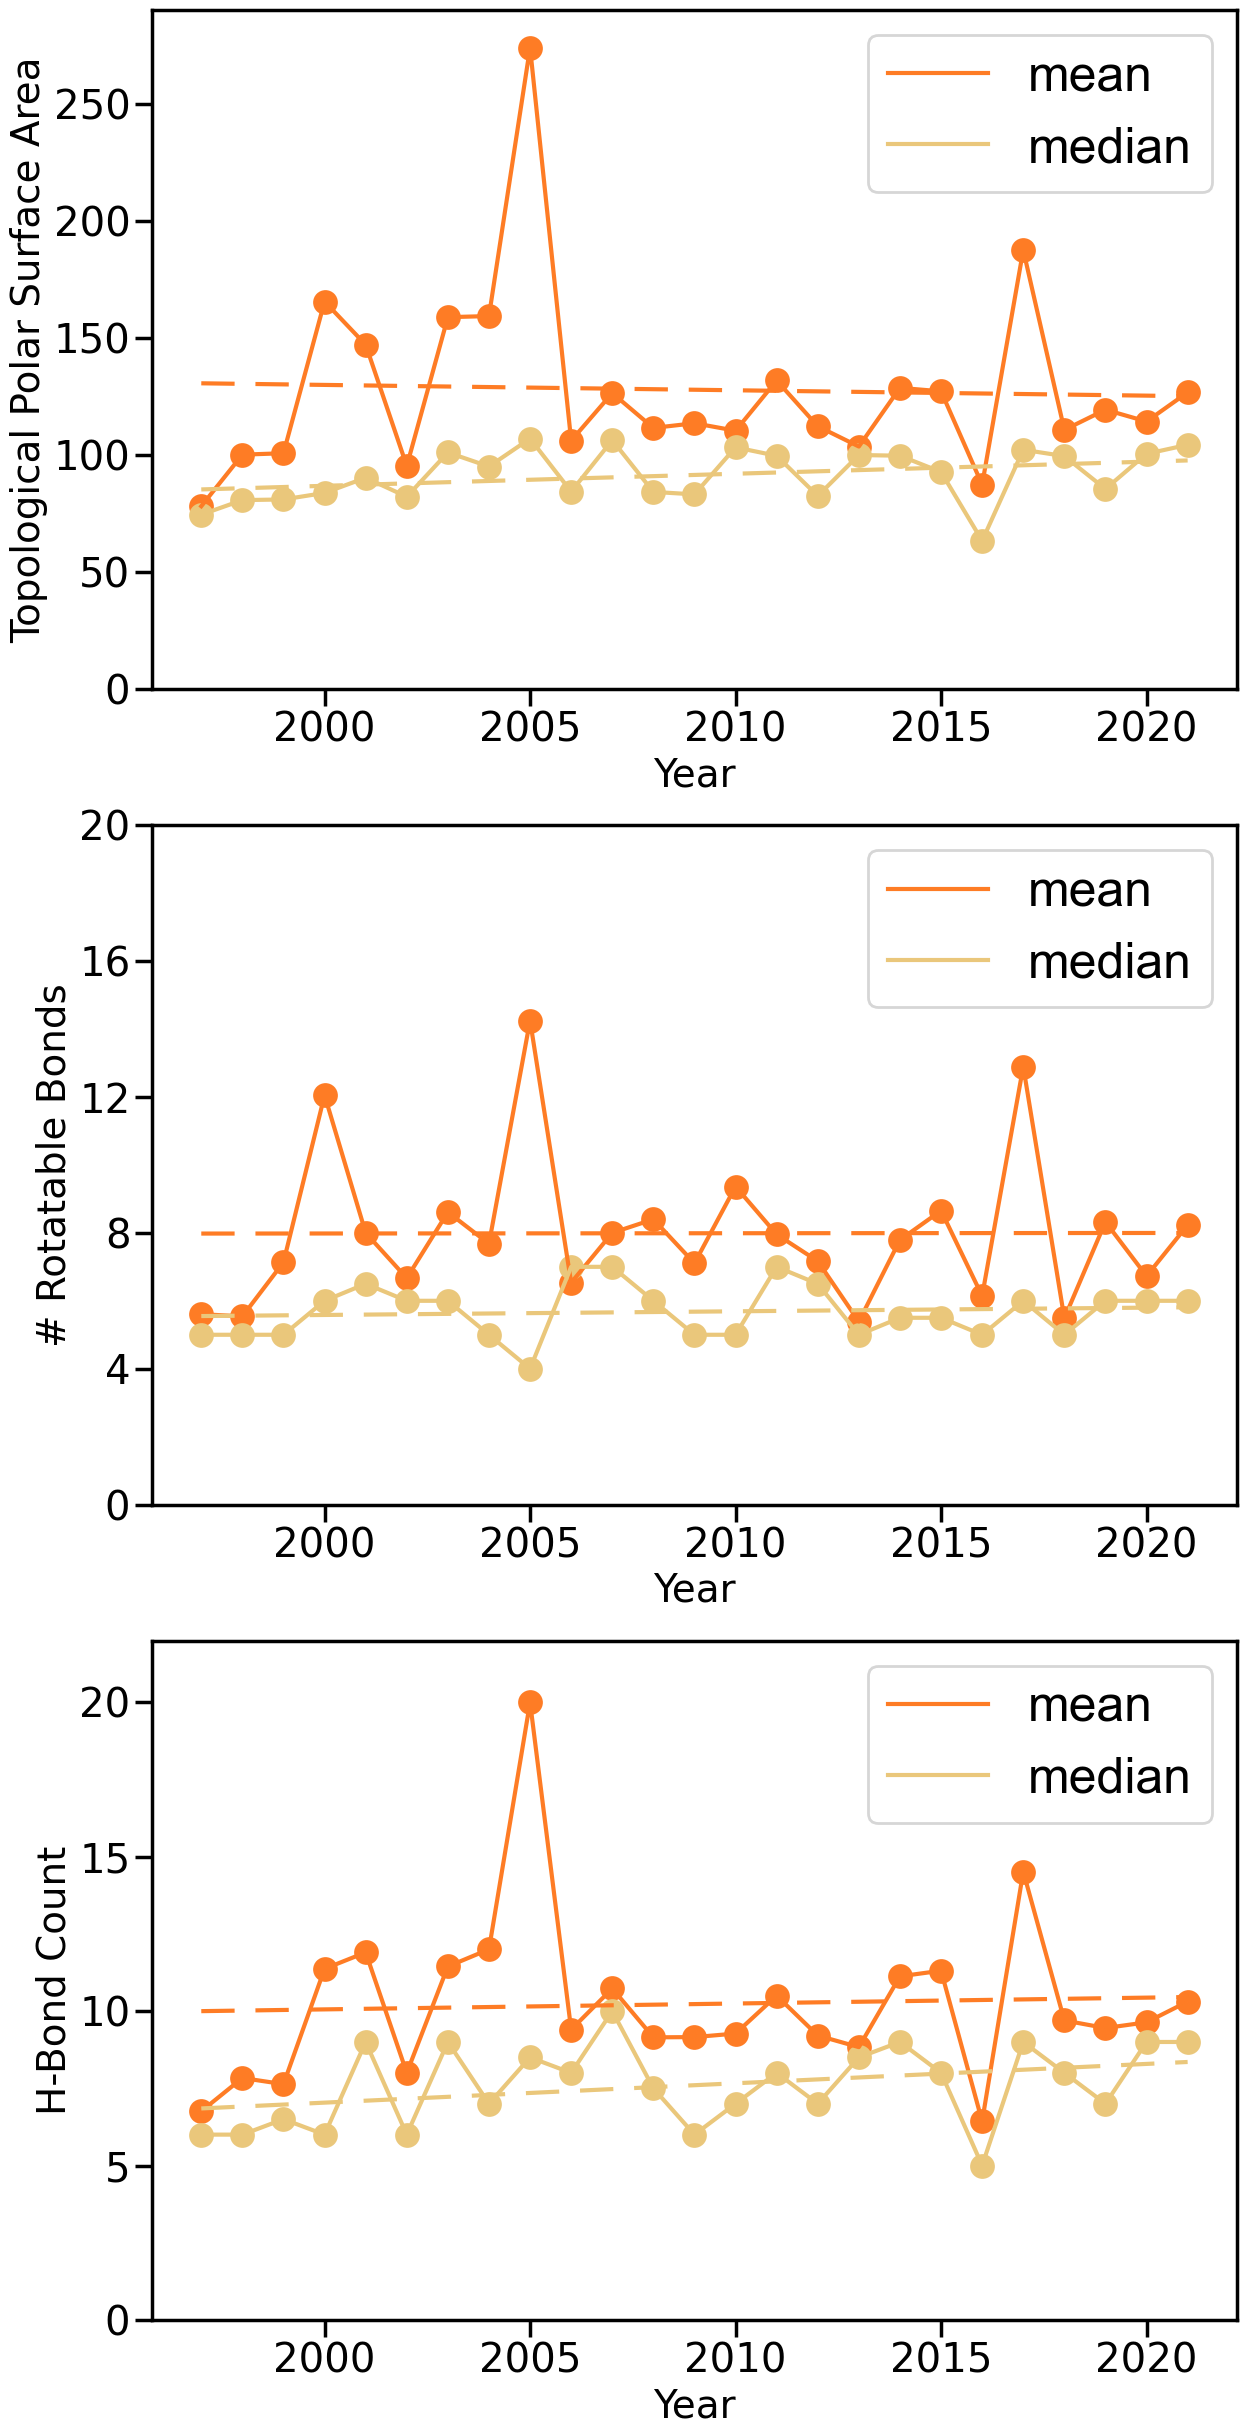

In [37]:
# creating image
fig, axs = plt.subplots(3, 1, figsize=(14, 30))

# plotting graphs
parameter_by_year(drugs, "tpsa", fig, axs[0], "upper right", (0, 290))
parameter_by_year(drugs, "rb", fig, axs[1], "upper right", (0, 20))
parameter_by_year(drugs, "h_sum", fig, axs[2], "upper right", (0, 22))

axs[1].set_yticks(list(range(0, 22, 4)))
axs[2].set_yticks(list(range(0, 22, 5)))

# saving img
fig.savefig(f"../imgs/veber/parameters_by_years_veber.png", dpi=300)


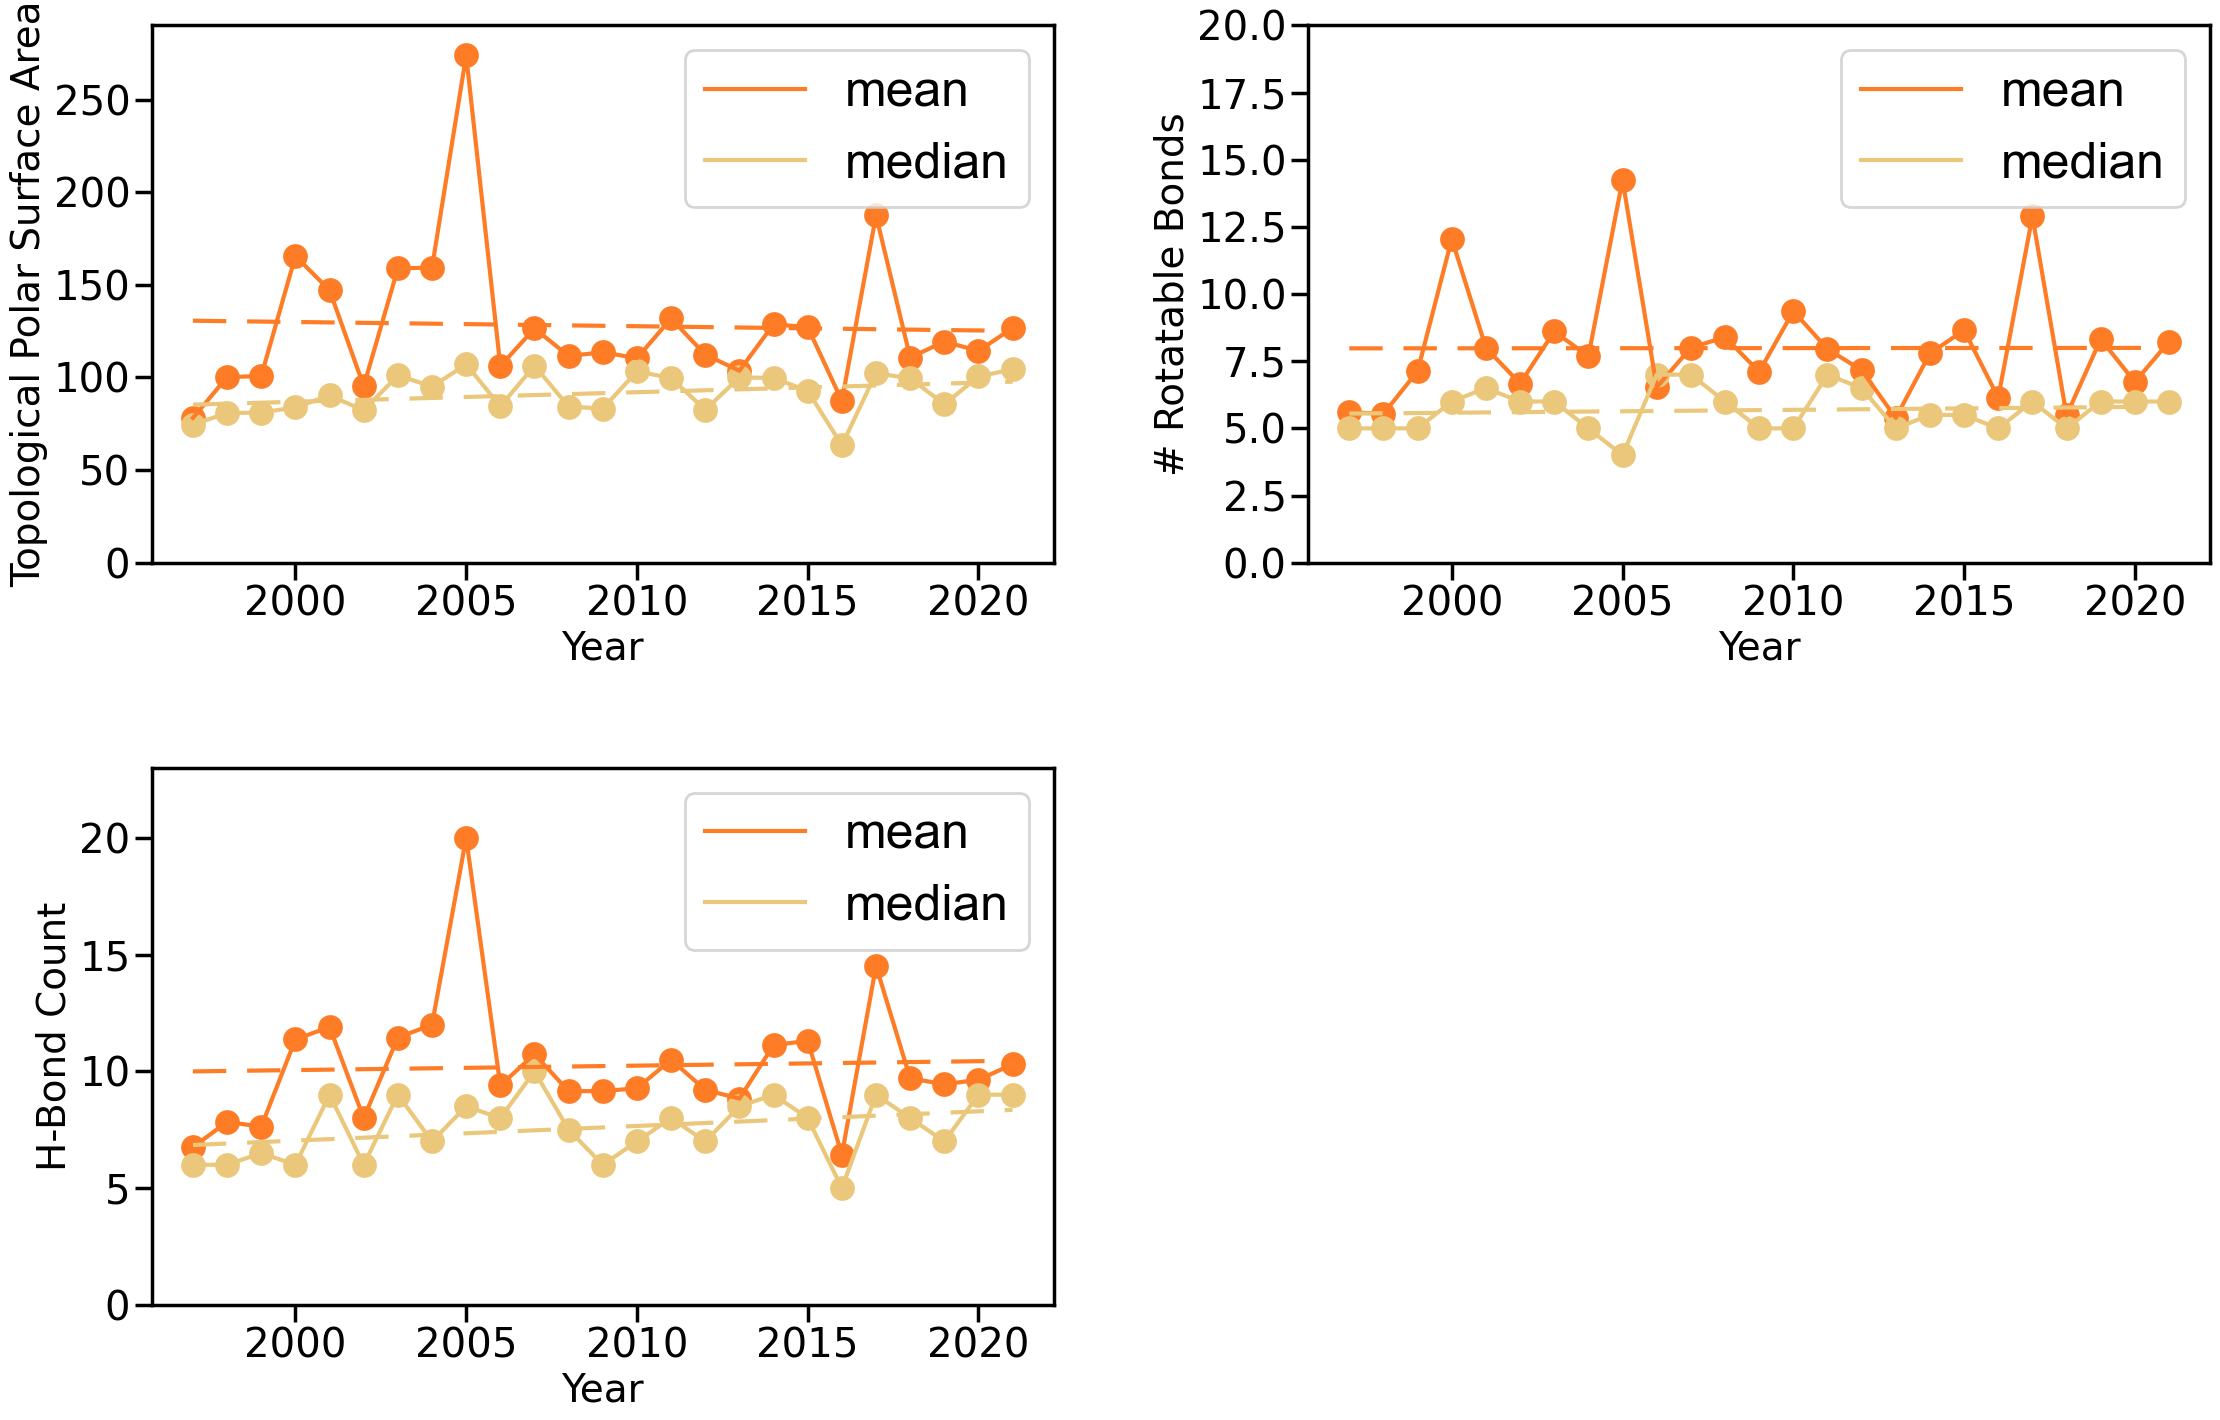

In [44]:
# creating image
fig, axs = plt.subplots(2, 2, figsize=(24, 16))
axs[1][1].axis('off')
# plotting graphs
parameter_by_year(drugs, "tpsa", fig, axs[0][0], "upper right", (0, 290))
parameter_by_year(drugs, "rb", fig, axs[0][1], "upper right", (0, 20))
parameter_by_year(drugs, "h_sum", fig, axs[1][0], "upper right", (0, 23))

# saving img
#adding padding to the plots
fig.tight_layout(pad=3.0)
fig.savefig(f"../imgs/veber/parameters_by_years_veber_alternative.png", dpi=300)

# Libraries Versions

In [45]:
session_info.show()
